# NYPD 911 Call Data Analysis

We've collected a dataset of 911 calls for $1,734$ days from 2018-01-01 to 2022-09-30. Let's read our csv file and plot this data.

In [1]:
# import useful libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read in csv file
calls = pd.read_csv("NYPD_Calls_by_date.csv")

# convert dates to datetime type
calls['dates'] = pd.to_datetime(calls['dates'])

print(calls.shape)
calls

(1734, 5)


,dates,#calls,weekday,day,month
0,2018-01-01,16007,0,1,1
1,2018-01-02,16324,1,2,1
2,2018-01-03,16980,2,3,1
3,2018-01-04,14831,3,4,1
4,2018-01-05,17251,4,5,1
...,...,...,...,...,...
1729,2022-09-26,19630,0,26,9
1730,2022-09-27,20609,1,27,9
1731,2022-09-28,21410,2,28,9
1732,2022-09-29,20929,3,29,9


Text(0.5, 1.0, '# of 911 Calls from 2018-01-01 to 2022-09-30')

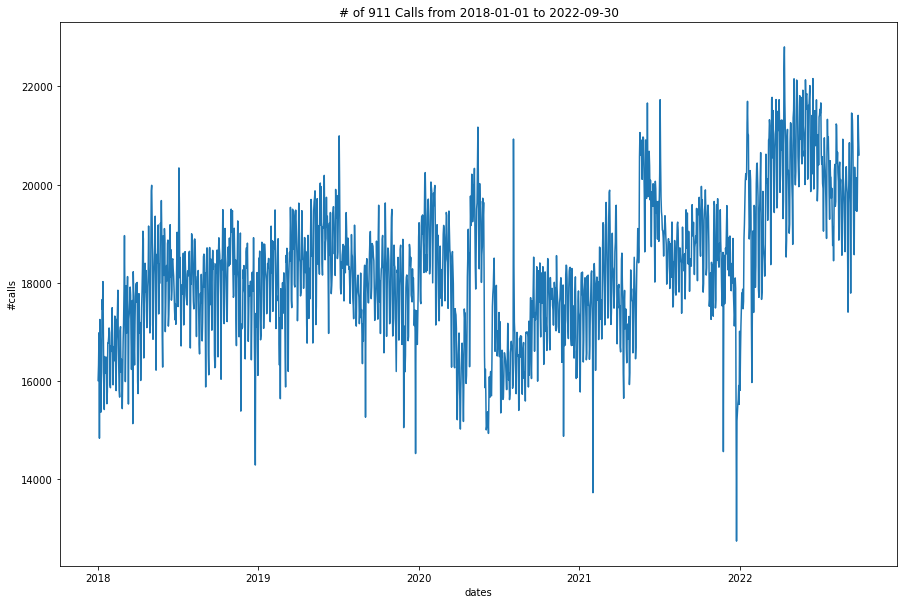

In [3]:
plt.figure(figsize = (15, 10))
sns.lineplot(data = calls, x = 'dates', y = '#calls')
plt.title("# of 911 Calls from 2018-01-01 to 2022-09-30")

## **Rolling Means**

Let's take a look at the **weekly** and **monthly rolling means** of these counts to smooth out our data

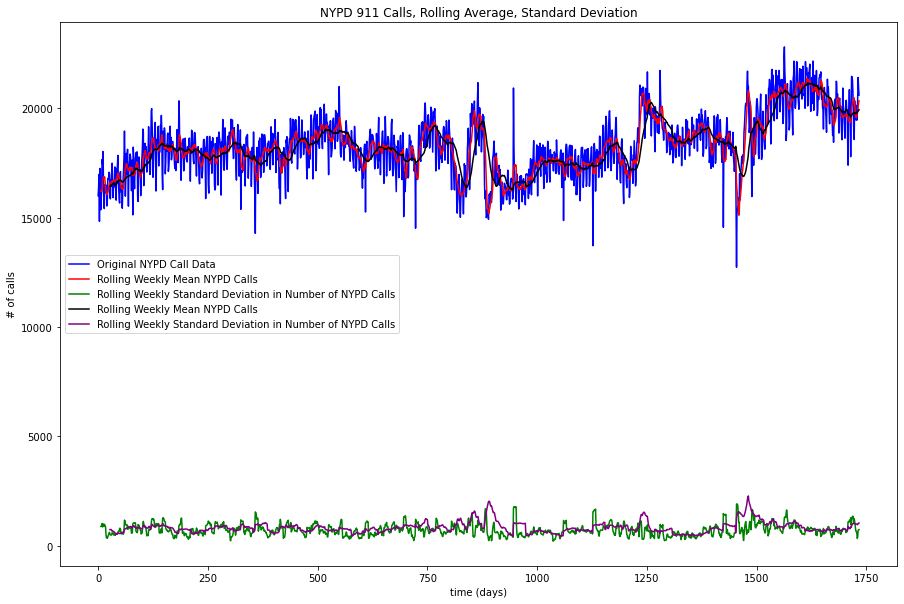

In [4]:
# get weekly rolling means
rolling_mean_weekly = calls['#calls'].rolling(7).mean()
rolling_std_weekly = calls['#calls'].rolling(7).std()

# get monthly rolling means
rolling_mean_monthly = calls['#calls'].rolling(28).mean()
rolling_std_monthly = calls['#calls'].rolling(28).std()

# drop null values
rolling_mean_weekly.dropna(inplace=True)
rolling_std_weekly.dropna(inplace=True)
rolling_mean_monthly.dropna(inplace=True)
rolling_std_monthly.dropna(inplace=True)

# plot our data with rolling means
plt.figure(figsize = (15, 10))
plt.plot(calls['#calls'], color="blue",label="Original NYPD Call Data")

plt.plot(rolling_mean_weekly, color="red", label="Rolling Weekly Mean NYPD Calls")
plt.plot(rolling_std_weekly, color="green", label = "Rolling Weekly Standard Deviation in Number of NYPD Calls")

plt.plot(rolling_mean_monthly, color="black", label="Rolling Weekly Mean NYPD Calls")
plt.plot(rolling_std_monthly, color="purple", label = "Rolling Weekly Standard Deviation in Number of NYPD Calls")

plt.title("NYPD 911 Calls, Rolling Average, Standard Deviation")
plt.ylabel("# of calls")
plt.xlabel('time (days)')
plt.legend(loc="best")

We see that our data has a lot of **variability** even when smoothed out.

## **Trends and Seasonality**

Since we'll be carrying out some **forecasting** later on with our data, let's explore the **seasonality** and **trends** in this data. First, let's check whether these 911 calls are a **stationary time series**.

In [5]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(calls['#calls'],autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
                          "Metric":["Test Statistics", "p-value", "No. of lags used", "Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

        Values                       Metric
0    -3.547926              Test Statistics
1     0.006838                      p-value
2    21.000000             No. of lags used
3  1712.000000  Number of observations used
4    -3.434175          critical value (1%)
5    -2.863230          critical value (5%)
6    -2.567670         critical value (10%)


We have a **p-value** of $0.0068$, which is much lower than our baseline of $0.05$ so we have some confidence that our data is **stationary**.

Next, let's look at whether the number of calls in previous days has any **autocorrelation** with the number of calls we receive today.

In [6]:
autocorrelation_lag1 = calls['#calls'].autocorr(lag=1)
print("One Day Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = calls['#calls'].autocorr(lag=3)
print("Three Day Lag: ", autocorrelation_lag3)

autocorrelation_lag7 = calls['#calls'].autocorr(lag=7)
print("Weekly Lag: ", autocorrelation_lag7)

autocorrelation_lag14 = calls['#calls'].autocorr(lag=14)
print("Biweekly Lag: ", autocorrelation_lag14)

autocorrelation_lag28 = calls['#calls'].autocorr(lag=28)
print("Monthly Lag: ", autocorrelation_lag28)

One Day Lag:  0.8208583666506558
Three Day Lag:  0.6064542417905486
Weekly Lag:  0.7682834804908122
Biweekly Lag:  0.685376440331461
Monthly Lag:  0.579413965971173


Interestingly, the number of calls we received yesterday, a week ago, and up to two weeks ago has notable **autocorrelation** with how many calls we can expect to receive today!

Finally, let's check to see whether there's monthly or yearly **seasonality** within our data.

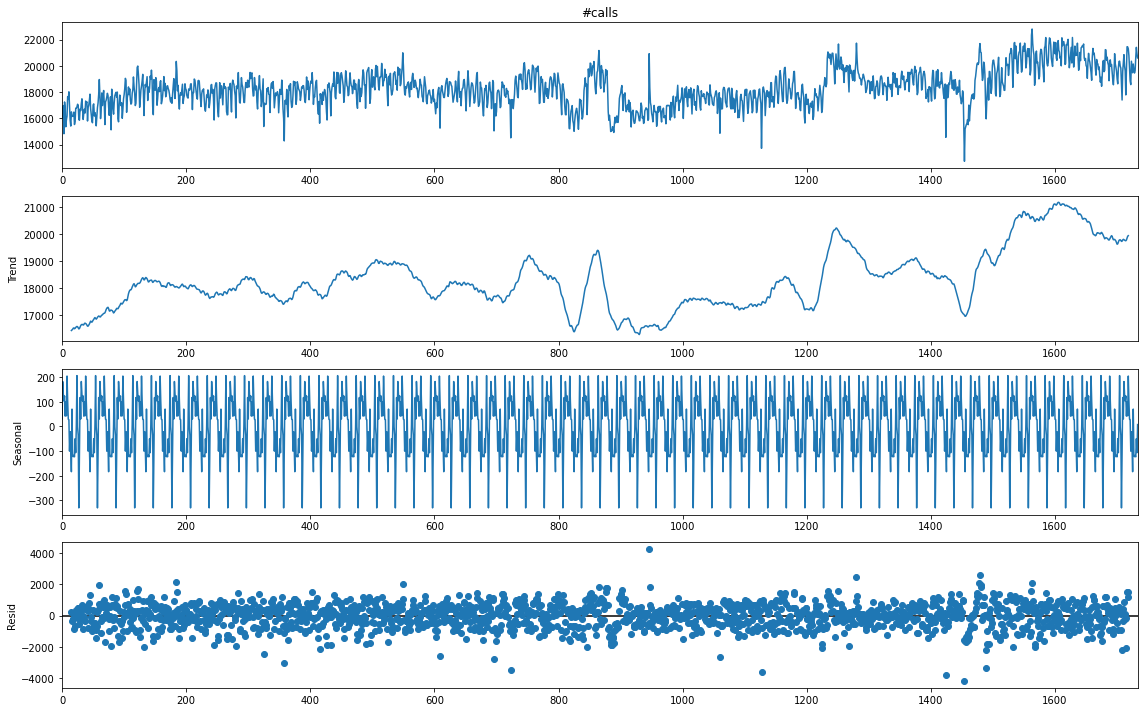

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# check for monthly seasonality
decompose = seasonal_decompose(calls['#calls'], model='additive', period=30)
fig = decompose.plot()
fig.set_size_inches((16, 10))
fig.tight_layout()
plt.show()

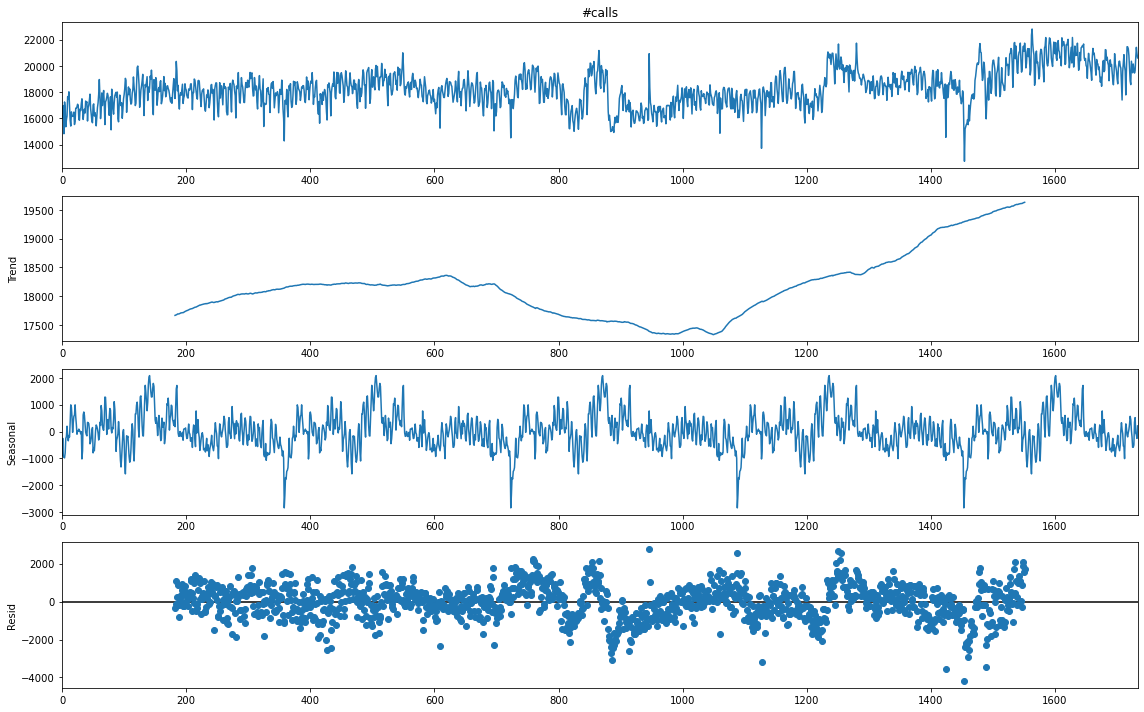

In [8]:
# check for yearly seasonality
decompose = seasonal_decompose(calls['#calls'], model='additive', period=365)
fig = decompose.plot()
fig.set_size_inches((16, 10))
fig.tight_layout()
plt.show()

There appears to be some seasonality both monthly as well as yearly within our data.